
# DAG Visualizations with `dagviz` — Core & Blockchain Context

This notebook uses **[dagviz](https://wimyedema.github.io/dagviz/)** to render DAGs directly inside Jupyter.

- **Part 1 – Core DAG:** Build a small DAG with `networkx`, validate acyclicity, and render it using `dagviz` (SVG inside the notebook).
- **Part 2 – Blockchain Context:** A minimal DAG-ledger simulation where each new transaction references two earlier **parents** (tips). We render the resulting transaction graph with `dagviz` and chart a tiny metric.

> References: the official dagviz page and API docs show how to call `render_svg` and display in notebooks. (Install via `pip install dagviz`.)

In [3]:

# If needed, install dependencies in your environment (uncomment to run locally)
# !pip install dagviz networkx


In [4]:

from collections import defaultdict, deque
import random
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import SVG, display

import dagviz  # requires: pip install dagviz

random.seed(42)



## Part 1 — Core DAG with `dagviz`

We construct a small **Directed Acyclic Graph (DAG)** and use `dagviz.render_svg(G)` to produce an SVG.  
`dagviz` expects a **DAG**; edges should indicate *data/control flows from predecessors to successors*.


Acyclic? True
Topological order: ['A', 'B', 'C', 'D', 'E', 'F']


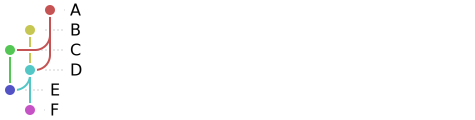

In [5]:

# Build a small DAG
G = nx.DiGraph()
G.add_nodes_from(list("ABCDEF"))

edges = [
    ("A","C"), ("A","D"),
    ("B","D"),
    ("C","E"),
    ("D","E"), ("D","F"),
]
G.add_edges_from(edges)

# Quick validations
is_acyclic = nx.is_directed_acyclic_graph(G)
topo = list(nx.topological_sort(G))
print("Acyclic?", is_acyclic)
print("Topological order:", topo)

# Render SVG with dagviz
svg_str = dagviz.render_svg(G)   # returns an SVG string
display(SVG(svg_str))



### Optional: Alternate rendering via `Metro` helper

`dagviz.Metro(G)` returns a small object that Jupyter can render as HTML automatically.


In [6]:

dagviz.Metro(G)  # Jupyter will render this automatically as HTML/SVG



## Part 2 — Blockchain‑Style DAG (Toy Ledger)

In some ledger designs (e.g., *Tangle‑like*), a new transaction **approves** a few earlier **parents**.  
We model this by adding edges **parent → child** (parents are predecessors; child is the new transaction).

**Toy rules**
- Start with a **genesis** node.
- Each new transaction picks up to `k=2` current **tips** (nodes without successors) as parents (fallback to existing nodes if too few tips).
- Add edges `parent → new_tx` to keep the graph acyclic and aligned with `dagviz` expectations.


Is DAG? True
Nodes: 31 Edges: 59


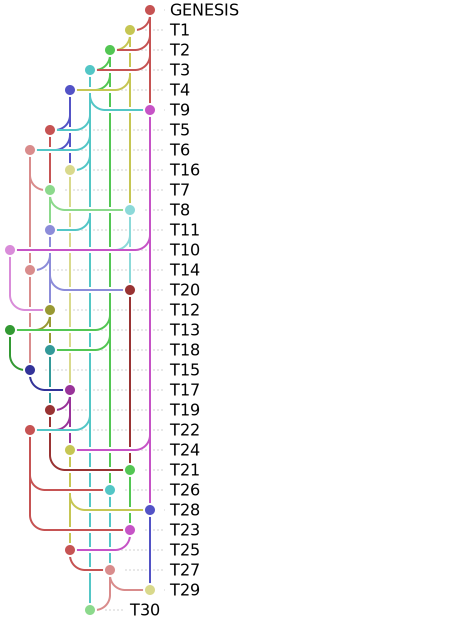

In [7]:

class ToyLedger:
    def __init__(self):
        self.G = nx.DiGraph()
        self.counter = 0
        self.tips = set()
        self._add_genesis()

    def _new_id(self):
        i = self.counter
        self.counter += 1
        return f"T{i}"

    def _add_genesis(self):
        g = self._new_id()
        self.G.add_node(g, label="GENESIS")
        self.tips.add(g)

    def add_tx(self, parents):
        tx = self._new_id()
        self.G.add_node(tx)
        if not parents:
            parents = list(self.tips)[:2]
        for p in parents:
            self.G.add_edge(p, tx)  # parent → child
        # Update tips: parents are no longer tips; the new tx is a tip
        for p in parents:
            if p in self.tips and self.G.out_degree(p) > 0:
                self.tips.remove(p)
        self.tips.add(tx)
        return tx

    def pick_parents(self, k=2):
        tips = list(self.tips)
        if len(tips) >= k:
            return random.sample(tips, k)
        # Fallback: sample any existing nodes to ensure growth
        nodes = list(self.G.nodes)
        return random.sample(nodes, min(k, len(nodes)))

    def simulate(self, n_new=30, k=2):
        for _ in range(n_new):
            parents = self.pick_parents(k=k)
            self.add_tx(parents)

ledger = ToyLedger()
ledger.simulate(n_new=30, k=2)

print("Is DAG?", nx.is_directed_acyclic_graph(ledger.G))
print("Nodes:", ledger.G.number_of_nodes(), "Edges:", ledger.G.number_of_edges())

# Render with dagviz
svg_ledger = dagviz.render_svg(ledger.G)
display(SVG(svg_ledger))



### Tip Count Over Insertions (Tiny Metric)

We measure the number of **tips** (transactions without children) as the ledger grows.


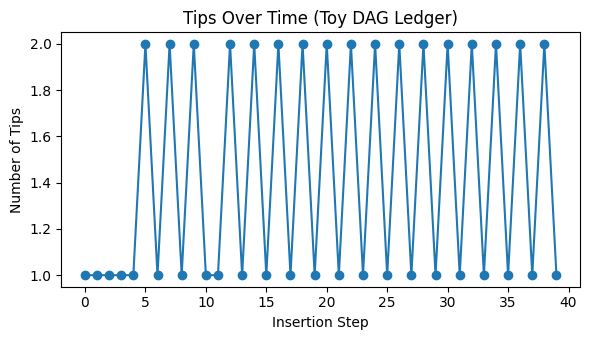

In [8]:

def tips_over_time(n_steps=30, k=2):
    series = []
    L = ToyLedger()
    for _ in range(n_steps):
        series.append(len(L.tips))
        parents = L.pick_parents(k=k)
        L.add_tx(parents)
    return series

series = tips_over_time(40, k=2)

plt.figure(figsize=(6,3.5))
plt.plot(range(len(series)), series, marker='o')
plt.xlabel("Insertion Step")
plt.ylabel("Number of Tips")
plt.title("Tips Over Time (Toy DAG Ledger)")
plt.tight_layout()
plt.show()



### Save SVGs (optional)


In [9]:

# with open("core_dag.svg", "w", encoding="utf-8") as f:
#     f.write(svg_str)
# with open("ledger_dag.svg", "w", encoding="utf-8") as f:
#     f.write(svg_ledger)
#
# print("Saved:", "core_dag.svg", "ledger_dag.svg")


Saved: core_dag.svg ledger_dag.svg
